In [598]:
#
# Simulate an R9 run on nanopore
# The run is <24 hours
# Fixed concentration (mean time to capture DNA is constant)
#
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as T

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from functools import partial

In [636]:
datatypes = [
    ('total_num_reads', np.int),        ('total_dna_read', np.int),
    ('num_minutes', np.float),
    ('num_active_pores_start', np.int), ('num_active_pores_end', np.int),
    ('mean_input_dna_len_estimate', np.float)]

# Currently:
# - read all DNA loaded (no dna breaking model)
# - one pore only that gets used up during the run
#
data2 = np.array([
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 100, 100,   100.0,    1,    1,  1.0),
  ( 200, 200,  1000.0,    1,    0,  1.0),
  ( 300, 300,  1000.0,    1,    0,  1.0),
  ( 400, 400,  1000.0,    1,    0,  1.0),
  ( 400, 400,  1000.0,    1,    0,  1.0),
], dtype=datatypes)

# 4 seconds to read, 60 seconds to capture
# 1000/64 = 15.625
# 156, 312, 468, 624
data = np.array([
  ( 3*14, 3*14*1000*.95,    1000.0/60,    3,    3,  1000.0),
  ( 3*15, 3*15*1000*1.05,   1000.0/60,    3,    3,  1000.0),
  ( 3*16, 3*16*1000*.95,    1000.0/60,    3,    3,  1000.0),
  ( 3*17, 3*17*1000*1.05,   1000.0/60,    3,    3,  1000.0),
# the following are all blocked
  ( 3*105, 3*100*1000*.95,  10000.0/60,    3,    0,  1000.0),
  ( 3*105, 3*100*1000*1.05, 10000.0/60,    3,    0,  1000.0),
  ( 3*105, 3*100*1000*.95,  30000.0/60,    3,    0,  1000.0),
  ( 3*105, 3*100*1000*1.05, 40000.0/60,    3,    0,  1000.0),
], dtype=datatypes)

# data = np.array([
#   (  52,  2000*52,     60.0,    1,    1,  2000.0),
#   (  52,  2000*52,     60.0,    1,    1,  2000.0),
#   (  47,  4000*47,     60.0,    1,    1,  4000.0),
#   (  94,  4000*94,    120.0,    1,    1,  4000.0),

#   ( 100, 4000*100,    240.0,    1,    0,  4000.0),
#   ( 150, 4000*150,    240.0,    1,    0,  4000.0),
#   (  75,  4000*75,    240.0,    1,    0,  4000.0),
#   ( 175, 4000*175,    240.0,    1,    0,  4000.0),
#   ( 175, 4000*175,    480.0,    1,    0,  4000.0),
# ], dtype=datatypes)

#data = np.array([
#   (  44,    69501,     60.0,    1,    1,  2000.0),
#   (  36,   275440,     60.0,    1,    1,  8000.0),
#   (  51,   127152,     60.0,    1,    1,  3000.0),
#   (  59,   161172,     60.0,    1,    1,  3000.0),
#   (  75,   582726,    120.0,    1,    1,  8000.0),
#   ( 134,   938406,    180.0,    1,    1,  8000.0),
#   ( 156,   312548,    180.0,    1,    1,  2000.0),
#   ( 167,   334427,    300.0,    1,    0,  2000.0),
#   ( 316,   587468,    600.0,    1,    0,  2000.0),
#   ( 344,  1046926,    600.0,    1,    0,  3000.0),
#   ( 470,  1534980,    600.0,    1,    1,  3000.0),
#   ( 319,   643649,   3000.0,    1,    0,  2000.0),
#   ( 285,   862323,   3000.0,    1,    0,  3000.0),
#   ( 932,  2851522,   3000.0,    1,    0,  3000.0),
#   (1107,  2215908,   3000.0,    1,    0,  2000.0),
#   (1134,  3361498,   3000.0,    1,    0,  3000.0),
#   (2044,  6054852,   3000.0,    1,    0,  3000.0),
#   (2051,  4024988,   3000.0,    1,    0,  2000.0),
#   (2195, 10884337,   3000.0,    1,    1,  5000.0),
#], dtype=datatypes)

fulldata = np.copy(data)

In [423]:
def test_Lognormal():
    """How does the Lognormal tau parameter map onto sd?"""
    nd = np.random.normal(loc=1000, scale=10, size=1000)
    print(np.mean(nd), np.std(nd))
    shape0,loc0,scale0 = st.lognorm.fit(nd, 1, floc=0)
    print(shape0, loc0, scale0)

    with pm.Model() as model:
        sd = 10
        input_dna_len = pm.Lognormal('test', mu=np.log(100000), tau=1)
        gam = pm.Gamma('gam', 10, 10)
        start = pm.find_MAP()
        print("start", start)
        step = pm.Metropolis()
        trace = pm.sample(1000, step, start=start)
        print(np.mean(trace['test']), np.std(trace['test']))
        print(np.mean(trace['gam']), np.std(trace['gam']))
        print(shape0, loc0, scale0, np.log(1000), 100)


def test_DensityDist():
    """How to use DensityDist to enforce a constraint"""
    import scipy.stats as sp
    from functools import partial

    def apply_mul_constraint(f1, f2, observed):
        # pm.log = <T.elemwise.Elemwise>
        diff = T.sub(T.mul(f1, f2), observed)
        # This works up to a point
        # like = -pm.log(T.sqr(diff))
        # This "normal" version just fails?
        # like = pm.log(T.exp(T.neg(T.sqr(diff))))
        # This is the most robust way to do it, allowing for unlikely f1/f2?
        like = -T.abs_(diff)

        print("values", len(list(observed)), observed, like)
        return like

    with pm.Model() as model:
        dd_data = np.repeat(1000,5) #np.random.normal(loc=250, scale=10, size=10)
        norm1 = pm.Normal('norm1', mu=10, sd=1)
        norm2 = pm.Normal('norm2', mu=20, sd=2)

        norm_constraint = partial(apply_mul_constraint, norm1, norm2)
        constraint = pm.DensityDist('constraint', norm_constraint, observed=dd_data)

        step = pm.Metropolis() # or NUTS
        trace = pm.sample(1000, step)
        print("mean", len(trace['norm1']), np.mean(trace['norm1']),
            len(trace['norm2']), np.mean(trace['norm2']))
        print(trace['norm1'][10:15], trace['norm1'][-5:])
        print(trace['norm2'][10:15], trace['norm2'][-5:])
        print(trace['norm1'][-1] * trace['norm2'][-1])

        f = plt.figure()
        ax = pm.traceplot(trace[-1000:],
                          figsize=(12,len(trace.varnames)*1.5),
                          lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

        plt.savefig("temp.png")

def test_normal():
    dd = np.random.normal(100, 10, size=1000)
    with pm.Model() as model:
        test_mu = pm.Flat('flat_mu', testval=100)
        test_sd = pm.Lognormal('flat_sd', mu=10, tau=1)
        normal = pm.Normal('normal', mu=test_mu, sd=test_sd)
        dens = pm.DensityDist('dd', lambda obs: -T.abs_(normal-obs), observed=dd)
        trace = pm.sample(10000, pm.Metropolis(), njobs=1)
        print("\n",pm.df_summary(trace[-N//2:]))

def test_constraint():
    def apply_constraint(Tf, f1, f2, observed):
        b = 1 # https://pymc-devs.github.io/pymc3/api.html#pymc3.distributions.continuous.Laplace
        nrm = 1/(2.*b)
        return T.log(T.mul(nrm, T.exp(T.neg(T.true_div(T.abs_(T.sub(Tf(f1,f2), observed)), b)))))

    # Model: 10 bases per second up to a limit of 100 bases
    n = 100
    times = np.arange(1,n+1)
    d1 = 10 * times
    d2 = np.random.poisson(100, size=d1.shape)
    dd = np.choose( d1>d2, [d1, d2])
    print(sorted(dd))
    
    with pm.Model() as model:
        _num_no_block = 10 #pm.Poisson("num_no_block", mu=10)
        num_nb_total = pm.Deterministic('num_nb_total', T.mul(_num_no_block, times))

        test_mu = pm.Flat('test_mu', testval=100)
        num_wi_block = pm.Poisson('num_wi_block', mu=test_mu) # should be 100
        min_con = partial(apply_constraint, T.minimum, num_nb_total, num_wi_block)
        total = pm.DensityDist('total', min_con, observed=dd)
        trace = pm.sample(10000, pm.Metropolis(), njobs=1)
        print("\n",pm.df_summary(trace[-N//2:], varnames=[v for v in trace.varnames if not 'num_nb_total' in v]))
        pm.traceplot(trace[-1000:])

def test_theano():
    a = T.constant([1,2,3])
    b = T.constant([0,1,4])
    c = T.sum(T.switch(T.lt(a,b), 0, 1))
    print(a,b)
    print(c.eval())
    
    
#test_Lognormal()
#test_DensityDist()
#test_constraint()
#test_normal()
test_theano()

TensorConstant{[1 2 3]} TensorConstant{[0 1 4]}
2


How to use Deterministic observations
(https://groups.google.com/forum/#!topic/pymc/gAImsliT34o)

    say you have two random variables with known priors
    X ~ f(theta_1)
    Y ~ g(theta_2)
    and you observe only the sum of the two, Z = X + Y.
    This is a case when you would like to have an observed deterministic.
    you can try to write Z as a stochastic but it could be very difficult, especially if Z is depend on more then two parameters.
    You cannot separately estimate theta_1 and theta_2 with only the sum to inform them, but if I were to build a model of this in PyMC, this is how I would approach it:
    theta_1 = Uniform('theta_1', 0, 100, value=2)
    theta_2 = Uniform('theta_2', 0, 100, value=2)
    x = Poisson('x', theta_1)
    y = Lambda('y', lambda x=x: z-x)
    @potential
    def ydist(y=y, theta=theta_2):
        return poisson_like(y, theta)
    So, the factor potential essentially constrains the resulting y values to be distributed according to a Poisson with parameter theta_2.

In [645]:
def apply_constraint(Tf, f1, f2, observed):
    """Use the closest of f1 and f2 to the observed values as the likelihood.
    T.min and T.minimum are not the same!"""
    if True:
        return -T.abs_(T.sub(Tf(f1, f2), observed))
    # Double exponential / Laplace
    b = 1 # 1 fails with NUTS (logp=-inf), 10/100 fails with NUTS too (not positive definite)
    nrm = 1/(2.*b)
    return T.log(T.mul(nrm, T.exp(T.neg(T.true_div(T.abs_(T.sub(Tf(f1,f2), observed)), b)))))

def apply_minsum_constraint(f1, f2, observed):
    """Use the closest of f1 and f2 to the observed values as the likelihood.
    T.min and T.minimum are not the same!"""
    if False:
        return -T.abs_(T.sub(T.minimum(f1, f2), observed))
    # Double exponential / Laplace
    b = 10 # 1 fails with ADVI (nan) https://pymc-devs.github.io/pymc3/api.html#pymc3.distributions.continuous.Laplace
    nrm = 1/(2.*b)
    return T.log(T.mul(nrm, T.exp(T.neg(T.true_div(T.abs_(T.sub(T.sum(T.minimum(f1,f2),axis=AXIS_PORES), observed)), b)))))

def apply_count_constraint(f1, f2, observed):
    b = 1 # https://pymc-devs.github.io/pymc3/api.html#pymc3.distributions.continuous.Laplace
    nrm = 1/(2.*b)
    # count the number of times f2 >= f1, i.e., the number of times reads_possible exceeds reads_blocked
    # if reads_possible > reads_blocked then the pore is unblocked
    val = T.sum(T.switch(T.lt(f1,f2),0,1)) 
    return T.log(T.mul(nrm, T.exp(T.neg(T.true_div(T.abs_(T.sub(val,observed)), b)))))

USE_ADVI = True
DOUBLE = True

if DOUBLE:
    data = np.copy(fulldata)
    data = data.repeat(1)
    print(data)

AXIS_RUNS, AXIS_PORES = 0, 1
MAX_PORES = 3
print(data.shape)

with pm.Model() as model:
    #
    # Inputs to the model
    #

    num_seconds_run = data['num_minutes'] * 60
    num_active_pores_start = data['num_active_pores_start']
    mean_input_dna_len_estimate = data['mean_input_dna_len_estimate']

    #
    # Priors
    #
    
    # These do not work if shape is specified. Fixable if necessary.
    Truncated0Normal1D = pm.Bound(pm.Normal, lower=0)
    Truncated0T1D = pm.Bound(pm.StudentT, lower=0)

    # The input DNA should have a mostly known size distribution, different for each run, same for each pore.
    # StudentT, variance = 1/lam
    #prior_input_dna_len_tau = 10
    #input_dna_len = pm.Lognormal('input_dna_len', mu=np.log(mean_input_dna_len), tau=prior_input_dna_len_tau,
    #                             testval=np.log(mean_input_dna_len), shape=data.shape)
    mean_input_dna_len = pm.StudentT('mean_input_dna_len', nu=3, mu=mean_input_dna_len_estimate, 
                                     sd=mean_input_dna_len_estimate/4., shape=data.shape)
    
    # How long does one pore wait to capture a segment of DNA?
    # This is concentration-dependent. I assume concentration is almost the same for all experiments
    # "Exponential describes the time between events in a Poisson process"
    # http://www.wolframalpha.com/input/?i=exponential(rate%3D1%2F50.)
    prior_mean_time_to_capture_dna = Truncated0T1D('prior_mean_time_to_capture_dna', nu=3, mu=60, sd=30)
    
    # Real one
    #mean_time_to_capture_dna = pm.Exponential('mean_time_to_capture_dna', lam=1/prior_mean_time_to_capture_dna, shape=data.shape)
    mean_time_to_capture_dna = Truncated0T1D('mean_time_to_capture_dna', nu=3, mu=prior_mean_time_to_capture_dna, sd=prior_mean_time_to_capture_dna/8, shape=data.shape)
    # This test shows that the constraint is working (but Bound fails if time_to_capture_dna is not a scalar):
    #mean_time_to_capture_dna = pm.Bound(pm.Exponential, lower=50)('mean_time_to_capture_dna', lam=1/prior_mean_time_to_capture_dna)

    # after a read finishes pores should rarely be blocked
    # a prior of 1% seems reasonable
    prior_p_pore_blocked_a, prior_p_pore_blocked_b, = 1, 99
    p_pore_blocked = pm.Beta('p_pore_blocked', alpha=prior_p_pore_blocked_a, beta=prior_p_pore_blocked_b)


    # I expect read speed to be between 200 and 300 (2 SDs)
    # I assume read_speed is due to some property of the chip (voltage) and doesn't change over time
    prior_mean_read_speed = Truncated0Normal1D('prior_mean_read_speed', mu=250, sd=10)
    prior_sd_read_speed = 10
    mean_read_speed = Truncated0Normal1D('mean_read_speed', mu=prior_mean_read_speed, sd=prior_sd_read_speed, shape=data.shape)

    # The time to read DNA is easily calculated
    mean_time_to_read_dna = pm.Deterministic('mean_time_to_read_dna', T.true_div(mean_input_dna_len, mean_read_speed))


    # Per pore, how many reads can I do before getting blocked?
    # This obeys a geometric distribution
    # Or use pm.Geometric if I am not using ADVI # instead of lam, p (same value though)
    num_reads_before_blockage = pm.Exponential('num_reads_before_blockage', lam=p_pore_blocked, 
                                               shape=(data.shape[0], MAX_PORES))

    # Per pore: a read includes waiting for DNA, then sequencing it
    num_reads_possible_in_time = pm.Deterministic('num_reads_possible_in_time',
        T.true_div(num_seconds_run, T.add(mean_time_to_capture_dna, mean_time_to_read_dna)))

    # ------------------------------------------
    # Constraints
    #

    # You can read until you get blocked
    # Sum over all pores
    # num_reads_possible_in_time.T using dimshuffle((0,'x')) does not work
    # using _broadcast version gives the same results so broadcasting is working as expected
    #num_reads_possible_in_time_broadcast = T.tile(num_reads_possible_in_time, (MAX_PORES,1))
    
    total_num_reads_constraint = partial(apply_minsum_constraint,
                                         num_reads_before_blockage, num_reads_possible_in_time.dimshuffle(0,'x'))
    constrain_total_num_reads = pm.DensityDist('constrain_total_num_reads', total_num_reads_constraint, observed=data['total_num_reads'])
    
    
    # How many pores are left at the end? e.g., 480 -> 420
    # Sum over pores???
    # num_reads_possible_in_time is per pore
    
    # per_run is mainly for printing
    num_reads_before_blockage_per_run = pm.Deterministic('num_reads_before_blockage_per_run', T.sum(num_reads_before_blockage, axis=AXIS_PORES))
    num_active_pores_end_constraint = partial(apply_count_constraint, 
                                              num_reads_before_blockage_per_run, num_reads_possible_in_time)
    constrain_num_active_pores_end = pm.DensityDist('constrain_num_active_pores_end', num_active_pores_end_constraint, observed=data['num_active_pores_end'])
    
    
    # Total DNA read is simply input_dna_len * total_num_reads
    total_dna_read_constraint = partial(apply_constraint, T.mul, mean_input_dna_len, constrain_total_num_reads)
    constrain_total_dna_read = pm.DensityDist('constrain_total_dna_read', total_dna_read_constraint, observed=data['total_dna_read'])
    
    
    # ----------------------------------------
    # Print and plot
    #
    # Then number of reads is the final output
    N = 10000

    if USE_ADVI:
        v_params = pm.variational.advi(n=100000, random_seed=1)
        trace = pm.variational.sample_vp(v_params, draws=10000)
    else:
        start = pm.find_MAP(fmin=sp.optimize.fmin_l_bfgs_b)
        print("start", start, model.logp(start))
        print("test_point", model.test_point)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(N, step, njobs=1, random_seed=1)

    q = pm.quantiles(trace['p_pore_blocked'], [2.5, 5, 95, 97.5, 32, 68])
    val1 = np.random.exponential(1./q[2.5], size=10).mean()
    val2 = np.random.exponential(1./q[97.5], size=10).mean()
    valx = [np.random.exponential(1./t, size=1)[0] for t in trace['p_pore_blocked']]
    
    print("\nvals", val1, val2)
    print("valx", np.mean(valx), np.std(valx), "mean 1/p", np.mean(1./trace['p_pore_blocked']))
    
    if not USE_ADVI:
        print("\nstart:", model.logp(trace[50]))
        print("end:", np.mean([model.logp(trace[i]) for i in range(-100,0)]))
    print(pm.df_summary(trace[-N//2:]))


[(42, 39900, 16.666666666666668, 3, 3, 1000.0)
 (45, 47250, 16.666666666666668, 3, 3, 1000.0)
 (48, 45600, 16.666666666666668, 3, 3, 1000.0)
 (51, 53550, 16.666666666666668, 3, 3, 1000.0)
 (315, 285000, 166.66666666666666, 3, 0, 1000.0)
 (315, 315000, 166.66666666666666, 3, 0, 1000.0)
 (315, 285000, 500.0, 3, 0, 1000.0)
 (315, 315000, 666.6666666666666, 3, 0, 1000.0)]
(8,)
Applied lowerbound-transform to prior_mean_time_to_capture_dna and added transformed prior_mean_time_to_capture_dna_lowerbound_ to model.
Applied lowerbound-transform to mean_time_to_capture_dna and added transformed mean_time_to_capture_dna_lowerbound_ to model.
Applied logodds-transform to p_pore_blocked and added transformed p_pore_blocked_logodds_ to model.
Applied lowerbound-transform to prior_mean_read_speed and added transformed prior_mean_read_speed_lowerbound_ to model.
Applied lowerbound-transform to mean_read_speed and added transformed mean_read_speed_lowerbound_ to model.
Applied log-transform to num_rea

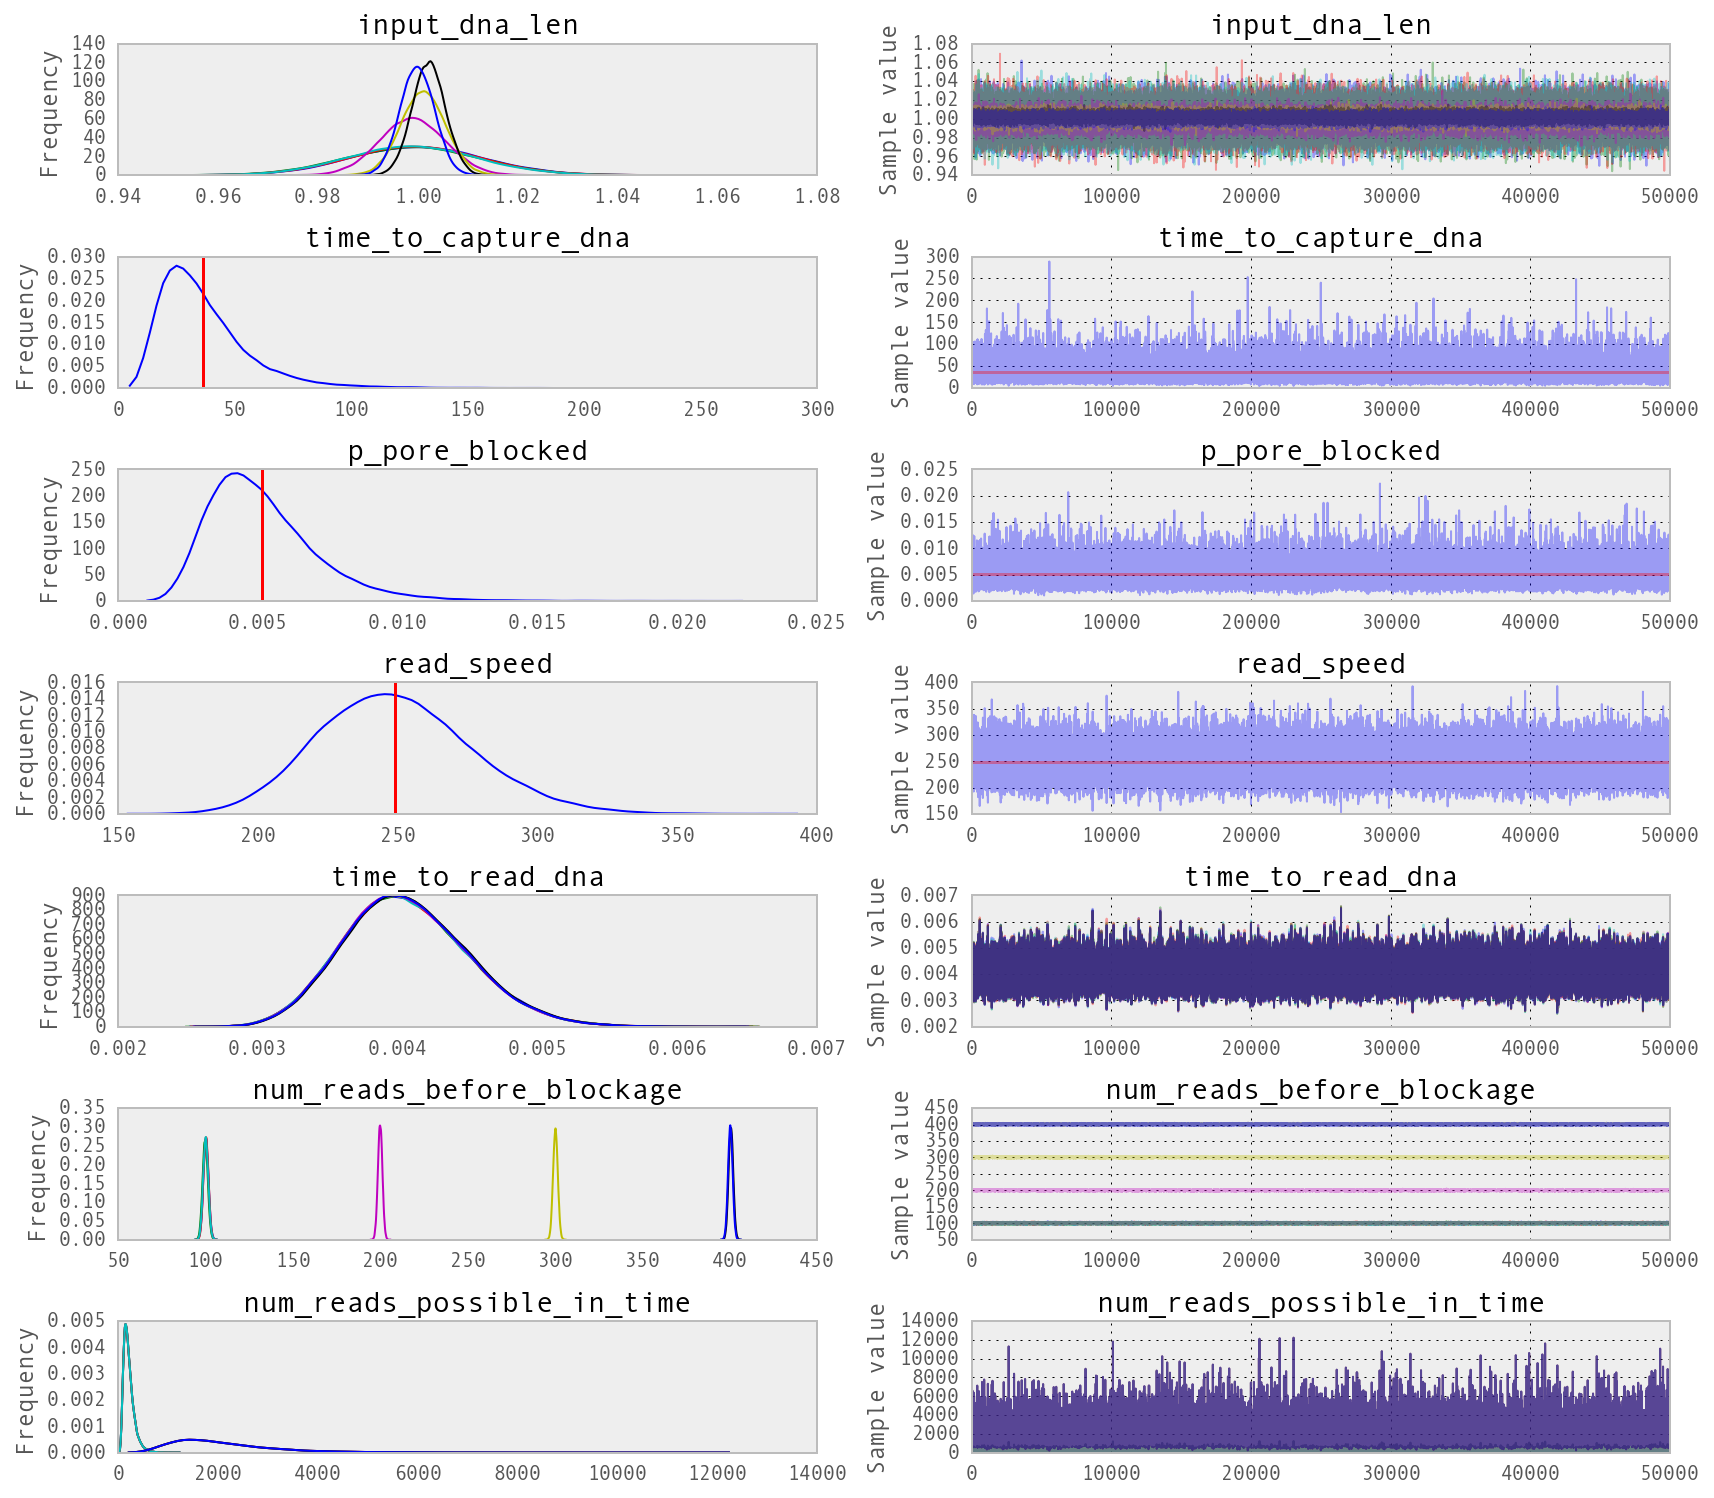

In [409]:
with pm.Model() as model:
    # Plotting is very slow for some reason
    pm.traceplot(trace[-N//2:], 
                 #varnames=['time_to_capture_dna', 'p_pore_blocked', 'read_speed','num_reads_before_blockage'],
                 figsize=(12,len(trace.varnames)*1.5),
                 lines={k: v['mean'] for k, v in pm.df_summary(trace[-N//2:]).iterrows()})